In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.special import factorial

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = "{:.3f}".format # Only display up to three decimal places

### Initial computations

In [2]:
elections = pd.read_csv('data/Elections/all_elections.csv', parse_dates = ['Date Filed', 'Date Closed'])
elections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33846 entries, 0 to 33845
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        33846 non-null  object        
 1   Case Number                   33846 non-null  object        
 2   Case Name                     33846 non-null  object        
 3   Status                        33846 non-null  object        
 4   Date Filed                    33846 non-null  datetime64[ns]
 5   Date Closed                   33455 non-null  datetime64[ns]
 6   Reason Closed                 33451 non-null  object        
 7   City                          33845 non-null  object        
 8   States & Territories          33846 non-null  object        
 9   Unit ID                       33846 non-null  object        
 10  Ballot Type                   33846 non-null  object        
 11  Tally Type                  

In [3]:
elections['Ballot Type'].value_counts()

Ballot Type
Single Labor Organization    31137
Two Labor Organizations       1604
Revised Single Labor Org       627
UD                             322
Three Labor Organizations      120
Revised Two Labor Orgs          36
Name: count, dtype: int64

In [4]:
# Restrict our attention to elections where only one union was on the ballot
single_elections = elections[elections['Ballot Type'] == 'Single Labor Organization']

In [5]:
# Restrict to representation elections
single_elections = single_elections[single_elections['Petition Type'] == 'RC']

In [6]:
# Set date closed as the index
single_elections.index = single_elections['Date Closed']

In [7]:
# Compute the percent yes vote in each election.
# Note that we could divide by the column 'Total Ballots Counted' but there are some cases where
# this seems to be erroneously equal to zero, e.g. 01-RC-270539. 
single_elections['Percent Votes Yes'] =  single_elections['Votes for Labor Union1'] / (single_elections[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum(axis = 1)) 
# Only display three decimal places
single_elections['Percent Votes Yes'] = single_elections['Percent Votes Yes'].round(3)

In [8]:
# Make it easier to read the win/loss outcome of the election
def get_outcome(row):
    if row['Percent Votes Yes'] > 0.5 or row['Reason Closed'] == "Certific. of Representative":
        return "Win"
    else:
        return "Loss"
single_elections['Outcome'] = single_elections.apply(get_outcome, axis = 1)

In [9]:
# Make a column that counts the number of new union members in successful union votes 
single_elections['Number Unionized'] = single_elections['No of Eligible Voters']*single_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

In [10]:
# Compute the duration of each case
single_elections['Duration'] = (single_elections['Date Closed']-single_elections['Date Filed']).apply(lambda x: x.days)

### General analysis

In [11]:
# Drop duplicate case numbers (some of these are re-runs of the same election)
single_elections = single_elections.drop_duplicates(subset=['Case Number'], keep = 'last')

In [12]:
# Resample to count the number of new union members per month
number_unionized_by_month = single_elections['Number Unionized'].resample("ME").sum()
number_unionized_by_day = single_elections['Number Unionized'].resample("D").sum()

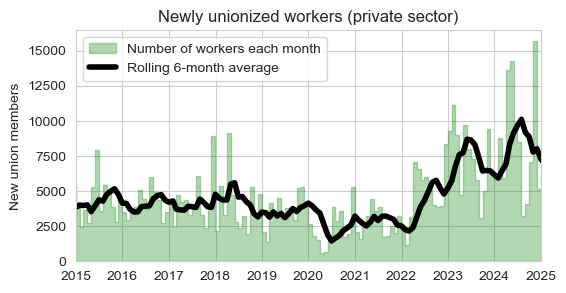

In [13]:
rolling_window_day = 182
rolling_window_month = 6
rolling_average_number_by_day = number_unionized_by_day.loc["2014-07":].rolling(rolling_window_day).mean()
rolling_average_number_by_month = number_unionized_by_month.loc["2014-07":].rolling(rolling_window_month).mean()
plt.figure(figsize = (6, 3))
plt.fill_between(number_unionized_by_month.loc["2014-12-31":].index, number_unionized_by_month.loc["2014-12-31":],  
                 color = 'green',
                 alpha = 0.3,
                 step='pre',
                label = f"Number of workers each month")
plt.plot(rolling_average_number_by_month.index, rolling_average_number_by_month, 
                 color = 'black',
                 linewidth = 4,
                label = f"Rolling 6-month average")
number_unionized_by_month.loc["2015":]
#plt.xlabel("Year")
plt.ylabel("New union members")
plt.ylim(bottom = 0)
plt.xlim(left = pd.to_datetime("2015-01-01"),right = pd.to_datetime("2025-1"))
plt.title(f"Newly unionized workers (private sector)")
plt.legend(loc = "upper left")
plt.savefig("new_union_members.png")
plt.show()

In [ ]:
single_elections['

In [14]:
# Compute and display the five largest elections each year
# IMPORTANT: This data should include the ALU win in Staten Island (29-RC-288020)
# but it doesn't because this case is still listed as "open" in the NLRB database,
# due to Amazon contesting it.
five_biggest_by_year = single_elections.drop_duplicates(subset = 'Case Number').sort_values(by = "No of Eligible Voters",ascending = False)
five_biggest_by_year = five_biggest_by_year.groupby(by = five_biggest_by_year['Date Closed'].dt.year).head(5)
five_biggest_by_year['Year'] = five_biggest_by_year['Date Closed'].dt.year
five_biggest_by_year = five_biggest_by_year.sort_values(by = ['Year','No of Eligible Voters'], ascending = False)
filt = five_biggest_by_year['Year'] >= 2010
five_biggest_by_year = five_biggest_by_year[filt][['Year', 'Case Number', 'City', 'States & Territories', 'Union', 'No of Eligible Voters', 'Turnout', 'Percent Votes Yes', 'Outcome', 'Case Name']]
five_biggest_by_year['City']  = (five_biggest_by_year['City'] + ", " + five_biggest_by_year['States & Territories'])
five_biggest_by_year.drop(columns = ['States & Territories'], inplace = True)
five_biggest_by_year["No of Eligible Voters"] = five_biggest_by_year["No of Eligible Voters"].astype(int)
five_biggest_by_year = five_biggest_by_year.reset_index()
# Set styling to highlight alternating years and left-align the text and column headers
five_biggest_by_year = five_biggest_by_year.style.apply(lambda x: len(five_biggest_by_year.columns)*['background-color:#DDDDDD' if x['Year']%2 == 0 else 'background-color:white'], axis = 1)
five_biggest_by_year = five_biggest_by_year.hide(["Date Closed"], axis = 1).hide(axis = 'index')
five_biggest_by_year = five_biggest_by_year.set_properties(**{'text-align': 'left'})
five_biggest_by_year = five_biggest_by_year.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
five_biggest_by_year.format(precision=3)

Year,Case Number,City,Union,No of Eligible Voters,Turnout,Percent Votes Yes,Outcome,Case Name
2026,20-RC-375118,"San Francisco, CA",NURSE UNION,331,0.849,0.722,Win,Sutter Bay Hospitals D/B/A Cpmc Davies Campus
2026,14-RC-372594,"Saint Louis, MO",TEAMSTERS,312,0.660,0.660,Win,"Zum Services, Inc."
2026,16-RC-374825,"Lancaster, TX",TEAMSTERS,311,0.656,0.522,Win,"United Natural Foods, Inc."
2026,16-RC-338816,"Roanoke, TX",TEAMSTERS,158,0.911,0.306,Loss,"The Martin-Brower Company, Llc"
2026,16-RC-372636,"Duncanville, TX",UFCW,105,0.610,0.156,Loss,Randall'S Food & Drug Lp
2025,13-RC-360358,"Melrose Park, IL",UFCW,1995,0.862,0.321,Loss,"Tony’S Finer Foods Enterprises, Llc"
2025,20-RC-360009,"Sacramento, CA",IBEW,1614,0.853,0.373,Loss,"Siemens Mobility, Inc."
2025,04-RC-364372,"Philadelphia, PA",UAW,1500,0.494,0.884,Win,Trustees Of The University Of Pennsylvania
2025,05-RC-364341,"Baltimore, MD",UAW,1451,0.398,0.948,Win,The Johns Hopkins University
2025,02-RC-361937,"Manhattan, NY",UAW,1206,0.636,0.741,Win,School Of Visual Arts Llc


In [17]:
filt = (single_elections['Duration'] >= 0) & (single_elections['Date Filed'] >= "2010")
durations = single_elections[filt]['Duration']
durations.index = single_elections[filt]['Date Filed']

In [18]:
# About 95% of cases are less than 200 days duration, so restrict our attention to those
print( (durations <= 200).sum()/(durations >= 0).sum() )
durations = durations[durations <= 200]

0.9448715453483846


In [19]:
# On average, a case lasts 55 days
durations.mean()

54.58015345795355

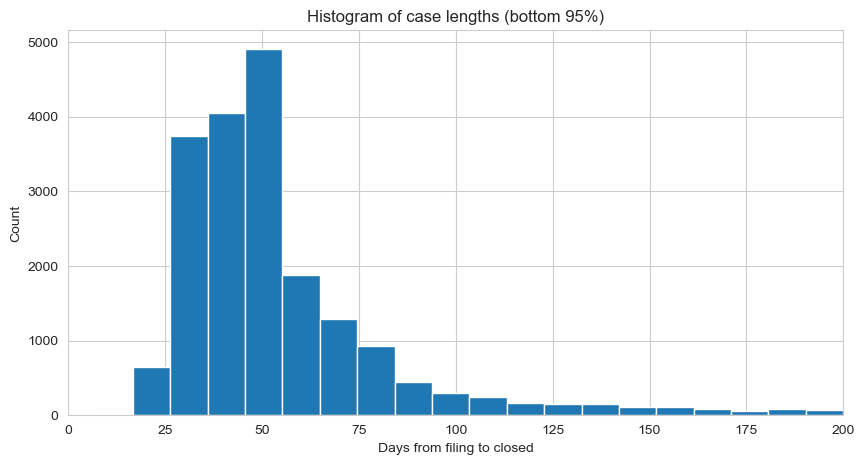

In [20]:
plt.figure(figsize = (10,5))
plt.hist(durations, bins = 20)
plt.xlim(left = 0, right = 200)
plt.ylabel("Count")
plt.xlabel("Days from filing to closed")
plt.title("Histogram of case lengths (bottom 95%)")
plt.show()


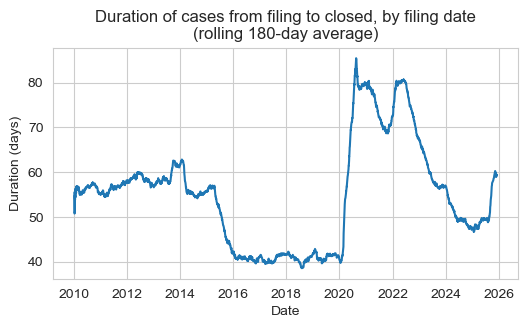

In [21]:
# Get rolling average of case durations
avg_duration_rolling = durations.sort_index().rolling("180D").agg(pd.Series.mean, skipna = True)
avg_duration_rolling = avg_duration_rolling[~avg_duration_rolling.index.duplicated(keep='last')]

plt.figure(figsize = (6,3))
plt.plot(avg_duration_rolling.index, avg_duration_rolling)
plt.xlabel("Date")
plt.ylabel("Duration (days)")
plt.title("Duration of cases from filing to closed, by filing date\n(rolling 180-day average)")
plt.show()

In [22]:
# Top ten unions
single_elections['Union'].value_counts().sort_values(ascending = False).head(11)

Union
TEAMSTERS         5315
SEIU              3020
UFCW              1786
OTHER             1716
IBEW              1586
IUOE              1578
IAM               1540
USW                727
AFSCME             597
CWA                589
SECURITY UNION     496
Name: count, dtype: int64

In [23]:
# Let's look at the elections for the top three
#unions_of_interest = ['TEAMSTERS', 'SEIU', 'UFCW', 'IAM', 'IBEW', 'IUOE', 'USW', 'AFSCME', 'CWA']
unions_of_interest = ['TEAMSTERS', 'SEIU', 'UFCW']
top_union_elections = single_elections[single_elections['Union'].apply(lambda x: x in unions_of_interest)]
top_union_elections = top_union_elections[['Turnout', 'Percent Votes Yes', 'Union', 'No of Eligible Voters']]
# Get rid of bad data outliers
top_union_elections = top_union_elections[top_union_elections['Turnout'] <= 1]
top_union_elections = top_union_elections[top_union_elections['Percent Votes Yes'] <= 1]
# Only look at elections with at least 20 workers
top_union_elections = top_union_elections[top_union_elections['No of Eligible Voters'] >= 20]

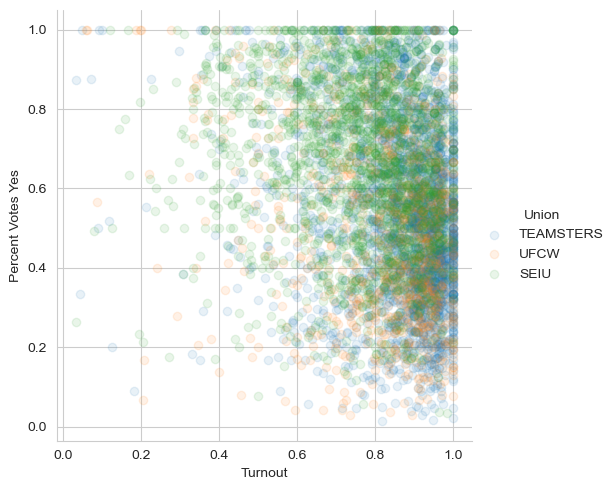

In [24]:
sns.lmplot(x = 'Turnout', y='Percent Votes Yes', data = top_union_elections,
            hue = 'Union', fit_reg = False,
          scatter_kws = {'alpha': 0.1})
plt.show()

In [25]:
# Let's look at the turnout and winrate for top unions
unions_of_interest = ['TEAMSTERS', 'SEIU', 'UFCW', 'IAM', 'IBEW', 'IUOE', 'USW', 'AFSCME', 'CWA']
top_union_elections = single_elections[single_elections['Union'].apply(lambda x: x in unions_of_interest)]
top_union_elections = top_union_elections[['Turnout', 'Percent Votes Yes', 'Union', 'No of Eligible Voters']]
# Get rid of bad data outliers
top_union_elections = top_union_elections[top_union_elections['Turnout'] <= 1]
top_union_elections = top_union_elections[top_union_elections['Percent Votes Yes'] <= 1]
# Only look at elections with at least 20 workers
top_union_elections = top_union_elections[top_union_elections['No of Eligible Voters'] >= 20]
top_union_elections.groupby(by='Union')[['Turnout', 'Percent Votes Yes']].mean().sort_values(by='Percent Votes Yes', ascending = False)

,Turnout,Percent Votes Yes
Union,,
SEIU,0.752,0.673
CWA,0.822,0.632
AFSCME,0.785,0.625
IAM,0.858,0.574
IUOE,0.867,0.573
TEAMSTERS,0.864,0.542
IBEW,0.847,0.528
UFCW,0.819,0.508
USW,0.886,0.506


In [26]:
closed_single_elections = single_elections[single_elections['Date Closed'].notna()].copy()
closed_single_elections.loc[:,'Year'] = closed_single_elections['Date Closed'].dt.year

In [27]:
votes_by_year = closed_single_elections.groupby(by = 'Year')[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum()
votes_by_year = votes_by_year.rename(columns = {'Votes for Labor Union1': "'Yes' votes", 'Votes Against':"'No' votes", 'Challenged Ballots':'Challenged ballots'})

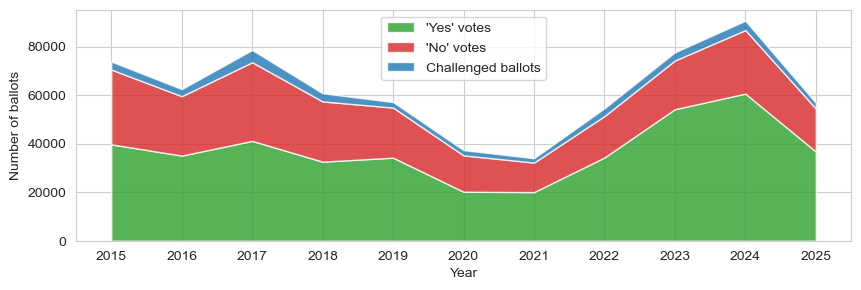

In [31]:
# NOTE: Unclip the range on votes_by_year below for later years
votes_by_year = votes_by_year.loc['2015':'2025']
fig,ax = plt.subplots(figsize = (10,3))
plt.stackplot(votes_by_year.index,
              votes_by_year.transpose().values,
              labels = votes_by_year.columns,
              alpha = 0.8,
              colors = ['tab:green', 'tab:red', 'tab:blue']
             )
plt.legend()
ax.set_ylabel("Number of ballots")
ax.set_xlabel("Year")
ax.set_xticks(range(2015, 2026))
ax.set_xticklabels(range(2015, 2026))
plt.show()

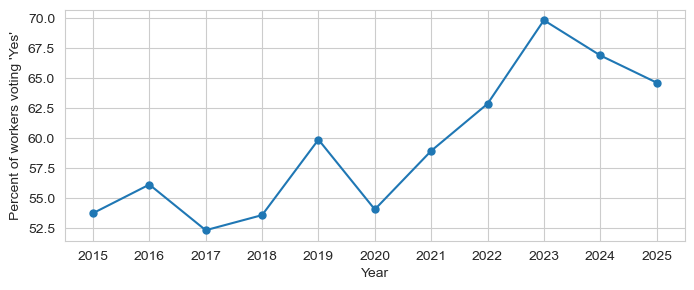

In [34]:
percent_yes_by_year = 100*votes_by_year["'Yes' votes"]/votes_by_year.sum(axis = 1)

fig,ax = plt.subplots(figsize = (8,3))
plt.plot(percent_yes_by_year, ".-", markersize=10)
ax.set_ylabel("Percent of workers voting 'Yes'")
ax.set_xlabel("Year")
ax.set_xticks(range(2015, 2026))
ax.set_xticklabels(range(2015, 2026))
plt.show()

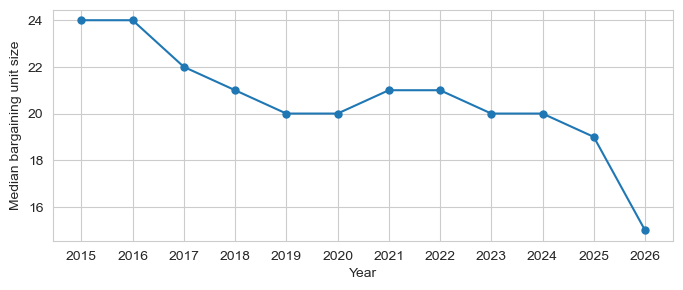

In [37]:
median_unit_size = closed_single_elections[closed_single_elections['Year'] > 2014].groupby(by = 'Year')['No of Eligible Voters'].median()

fig,ax = plt.subplots(figsize = (8,3))
plt.plot(median_unit_size, ".-", markersize=10)
ax.set_ylabel("Median bargaining unit size")
ax.set_xlabel("Year")
ax.set_xticks(range(2015, 2027))
ax.set_xticklabels(range(2015, 2027))
plt.show()

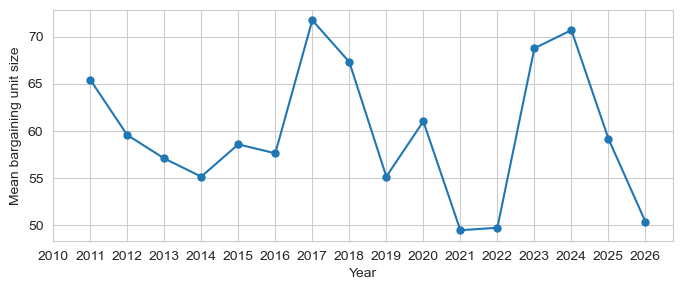

In [39]:
mean_unit_size = closed_single_elections[closed_single_elections['Year'] > 2010].groupby(by = 'Year')['No of Eligible Voters'].mean()

fig,ax = plt.subplots(figsize = (8,3))
plt.plot(mean_unit_size, ".-", markersize=10)
ax.set_ylabel("Mean bargaining unit size")
ax.set_xlabel("Year")
ax.set_xticks(range(2010, 2027))
ax.set_xticklabels(range(2010, 2027))
plt.show()

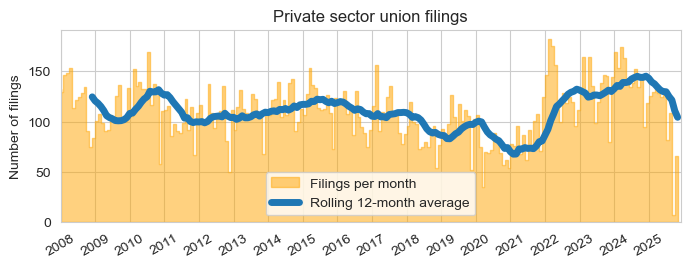

In [41]:
year = 2008
roll_window = 12
filt = (single_elections['Date Filed'] >= str(year)) & (single_elections['Date Filed'] < '2025-12')
filings_per_month = single_elections[filt]['Date Filed'].apply(lambda x: (x.year, x.month)).value_counts().sort_index()
roll = filings_per_month.rolling(roll_window).mean()

fig,ax = plt.subplots(figsize = (8,2.5))
plt.fill_between(range(len(filings_per_month)), filings_per_month.values, color = 'orange', label = 'Filings per month', zorder = 1, step='pre', alpha=0.5)
plt.plot(range(len(roll)), roll.values, color = 'tab:blue', alpha = 1.0, linewidth = 5, label = f'Rolling {roll_window}-month average', zorder = 2)
tix = range(0, len(filings_per_month), 12)
ax.set_xticks(tix)
ax.set_xticklabels([year+i//12 for i in tix], rotation = 30)
#ax.set_xlabel("Year")
ax.set_ylabel("Number of filings")
plt.xlim(left = 0, right = len(filings_per_month))
plt.ylim(bottom = 0)
plt.title("Private sector union filings")
plt.legend()
plt.savefig('charts/new_filings.png', bbox_inches='tight')
plt.show()

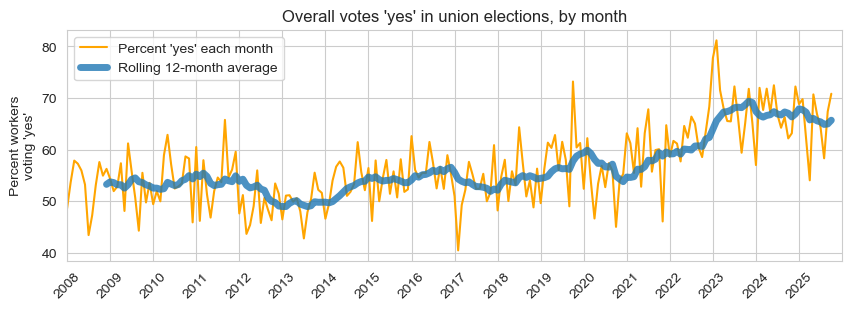

In [42]:
year = 2008
roll_window = 12
filt = (closed_single_elections['Date Closed'] >= str(year)) & (closed_single_elections['Date Closed'] < '2025-12')
ballots_by_month = closed_single_elections[filt].copy()
year_month = ballots_by_month['Date Closed'].apply(lambda x: (x.year, x.month))
ballots_by_month['Year, Month'] = year_month
ballots_by_month = ballots_by_month.groupby(by = 'Year, Month')[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum()
vote_rate_by_month = ballots_by_month['Votes for Labor Union1']/ballots_by_month.sum(axis = 1)
roll = vote_rate_by_month.rolling(roll_window).mean()

fig,ax = plt.subplots(figsize = (10,3))
plt.plot(range(len(vote_rate_by_month)), 100*vote_rate_by_month.values, color = 'orange', label = "Percent 'yes' each month", zorder = 1)
plt.plot(range(len(roll)), 100*roll.values, color = 'tab:blue', alpha = 0.8, linewidth = 5, label = f'Rolling {roll_window}-month average', zorder = 2)
tix = range(0, len(vote_rate_by_month), 12)
ax.set_xticks(tix)
ax.set_xticklabels([year+i//12 for i in tix], rotation = 45)
#ax.set_xlabel("Year")
ax.set_ylabel("Percent workers\nvoting 'yes'")
plt.xlim(left = tix[0])
plt.xlim(right = tix[-1]+12)
plt.title("Overall votes 'yes' in union elections, by month")
plt.legend()
plt.show()

In [43]:
# Looking at elections round beginning of 2023, when big spike in number voting yes
# Seems the spike is almost purely driven by academic votes: JHU, USC, UChicago, Boston U, Northwestern, and Yale.
filt = (single_elections['Date Closed'] >= '12-2022') & (single_elections['Date Closed'] <= '04-2023')
early_2023 = single_elections[filt]

In [44]:
early_2023.sort_values(by = 'Number Unionized', ascending = False).head(20)

,Region,Case Number,Case Name,Status,Date Filed,Date Closed,Reason Closed,City,States & Territories,Unit ID,...,Voting Unit (Unit B),Voting Unit (Unit C),Voting Unit (Unit D),Petition Type,Union,Turnout,Percent Votes Yes,Outcome,Number Unionized,Duration
Date Closed,,,,,,,,,,,,,,,,,,,,,
2023-01-18,"Region 01, Boston, Massachusetts",01-RC-305762,Yale University,Closed,2022-10-24,2023-01-18,Certific. of Representative,New Haven,CT,A,...,NaN,NaN,NaN,RC,UNITE HERE,0.634,0.851,Win,3214.000,86.000
2022-12-16,"Region 01, Boston, Massachusetts",01-RC-305360,Trustees Of Boston University,Closed,2022-10-18,2022-12-16,Certific. of Representative,Boston,MA,A,...,NaN,NaN,NaN,RC,SEIU,0.450,0.806,Win,3206.000,59.000
2023-03-24,"Region 13, Chicago, Illinois",13-RC-307974,University Of Chicago,Closed,2022-11-30,2023-03-24,Certific. of Representative,Chicago,IL,A,...,NaN,NaN,NaN,RC,UE,0.608,0.872,Win,3200.000,114.000
2023-02-08,"Region 05, Baltimore, Maryland",05-RC-309139,Johns Hopkins University,Closed,2022-12-19,2023-02-08,Certific. of Representative,Baltimore,MD,A,...,NaN,NaN,NaN,RC,UE,0.665,0.968,Win,3186.000,51.000
2023-01-23,"Region 13, Chicago, Illinois",13-RC-307313,Northwestern University,Closed,2022-11-17,2023-01-23,Certific. of Representative,Evanston,IL,A,...,NaN,NaN,NaN,RC,UE,0.671,0.816,Win,3000.000,67.000
2023-02-27,"Region 31, Los Angeles, California",31-RC-308858,University Of Southern California,Closed,2022-12-14,2023-02-27,Certific. of Representative,Los Angeles,CA,A,...,NaN,NaN,NaN,RC,UAW,0.602,0.847,Win,2861.000,75.000
2023-02-06,"Region 03, Buffalo, New York",03-RC-309080,University Of Vermont Medical Center,Closed,2022-12-19,2023-02-06,Certific. of Representative,Burlington,VT,A,...,NaN,NaN,NaN,RC,TEACHER UNION,0.581,0.814,Win,1996.000,49.000
2023-03-07,"Region 02, New York, New York",02-RC-308481,Montefiore Medical Center,Closed,2022-12-08,2023-03-07,Certific. of Representative,The Bronx,NY,A,...,NaN,NaN,NaN,RC,SEIU,0.637,0.764,Win,1188.000,89.000
2022-12-23,"Region 08, Cleveland, Ohio",08-RC-306216,Ultium Cells Llc,Closed,2022-10-31,2022-12-23,Certific. of Representative,Warren,OH,A,...,NaN,NaN,NaN,RC,UAW,0.932,0.978,Win,779.000,53.000


In [45]:
# Looking at elections round beginning of 2023, when big spike in number voting yes
# Seems the spike is almost purely driven by academic votes: JHU, USC, UChicago, Boston U, Northwestern, and Yale.
filt = (single_elections['Date Closed'] >= '2020') & (single_elections['Number Unionized'] > 1000)
single_elections[filt].sort_values(by = 'Percent Votes Yes')

,Region,Case Number,Case Name,Status,Date Filed,Date Closed,Reason Closed,City,States & Territories,Unit ID,...,Voting Unit (Unit B),Voting Unit (Unit C),Voting Unit (Unit D),Petition Type,Union,Turnout,Percent Votes Yes,Outcome,Number Unionized,Duration
Date Closed,,,,,,,,,,,,,,,,,,,,,
2023-05-22,"Region 10, Atlanta, Georgia",10-RC-315367,Blue Bird Body Company,Closed,2023-04-03,2023-05-22,Certific. of Representative,Fort Valley,GA,A,...,NaN,NaN,NaN,RC,USW,0.886,0.543,Win,1278.000,49.000
2023-06-14,"Region 21, Los Angeles, California",21-RC-307623,Sharp Grossmont Hospital,Closed,2022-11-21,2023-06-14,Certific. of Representative,La Mesa,CA,A,...,NaN,NaN,NaN,RC,SEIU,0.889,0.555,Win,1459.000,205.000
2021-05-10,"Region 01, Boston, Massachusetts",01-RC-271255,Mainehealth D/B/A Maine Medical Center,Closed,2021-01-12,2021-05-10,Certific. of Representative,Portland,ME,A,...,NaN,NaN,NaN,RC,NURSE UNION,0.892,0.557,Win,1962.000,118.000
2024-05-03,"Region 21, Los Angeles, California",21-RC-338073,Sharp Chula Vista Medical Center,Closed,2024-03-15,2024-05-03,Certific. of Representative,Chula Vista,CA,A,...,NaN,NaN,NaN,RC,SEIU,0.800,0.579,Win,1138.000,49.000
2024-11-25,"Region 07, Detroit, Michigan",07-RC-351617,Corewell Health East,Closed,2024-09-27,2024-11-25,Certific. of Representative,Southfield,MI,A,...,NaN,NaN,NaN,RC,TEAMSTERS,0.810,0.595,Win,9775.000,59.000
2023-05-08,"Region 09, Cincinnati, Ohio",09-RC-303303,"Dhl Express (Usa), Inc.",Closed,2022-09-13,2023-05-08,Certific. of Representative,Erlanger,KY,A,...,NaN,NaN,NaN,RC,TEAMSTERS,0.714,0.612,Win,1110.000,237.000
2025-07-02,"Region 21, Los Angeles, California",21-RC-363966,Southern California Edison Company,Closed,2025-04-17,2025-07-02,Certific. of Representative,Rosemead,CA,A,...,NaN,NaN,NaN,RC,OTHER,0.828,0.613,Win,1103.000,76.000
2022-04-19,"Region 01, Boston, Massachusetts",01-RC-289879,Massachusetts Institute Of Technology,Closed,2022-02-01,2022-04-19,Certific. of Representative,Cambridge,MA,A,...,NaN,NaN,NaN,RC,UE,0.705,0.621,Win,3823.000,77.000
2020-09-28,"Region 10, Atlanta, Georgia",10-RC-257615,"Mh Hospital Manager, Llc",Closed,2020-03-06,2020-09-28,Certific. of Representative,Asheville,NC,A,...,NaN,NaN,NaN,RC,NURSE UNION,0.794,0.654,Win,1733.000,206.000


In [46]:
academic_case_nos = ["01-RC-305762", # Yale
                  "01-RC-305360", # Boston University
                  "13-RC-307974", # U Chicago 
                  "05-RC-309139", # John's Hopkins
                  "13-RC-307313", # Northwestern
                  "31-RC-308858", # USC
                  "32-RC-316964", # Stanford
                  "10-RC-324546", # Emory
                  "03-RC-326874", # Cornell
                  "10-RC-313298", # Duke
                  "01-RC-336990", # Harvard (non-tenure track, PDs, etc)
                  "21-RC-331055", # Caltech
                  "01-RC-289879", # MIT
                 ]

In [47]:
academic_cases = closed_single_elections[closed_single_elections['Case Number'].apply(lambda x: x in academic_case_nos)]
print(f"Academic union votes were {100*academic_cases['Votes for Labor Union1'].sum() / academic_cases[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum().sum():.2f}% in favor, with {academic_cases[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum().sum()} ballots cast") 

Academic union votes were 84.22% in favor, with 22330.0 ballots cast


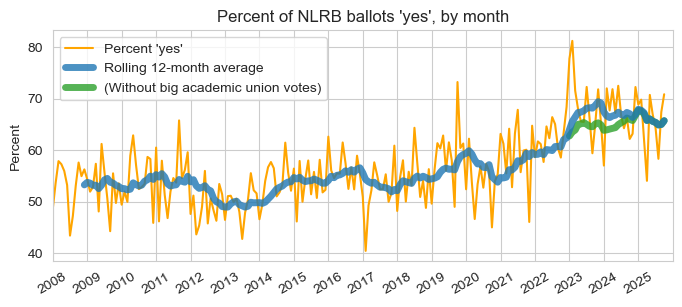

In [50]:
year = 2008
roll_window = 12
filt = (closed_single_elections['Date Closed'] >= str(year)) & (closed_single_elections['Date Closed'] < '2025-12')
ballots_by_month = closed_single_elections[filt].copy()
year_month = ballots_by_month['Date Closed'].apply(lambda x: (x.year, x.month))
ballots_by_month['Year, Month'] = year_month
ballots_by_month_nonacademic = ballots_by_month[ballots_by_month['Case Number'].apply(lambda x: x not in academic_case_nos)]

ballots_by_month = ballots_by_month.groupby(by = 'Year, Month')[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum()
vote_rate_by_month = ballots_by_month['Votes for Labor Union1']/ballots_by_month.sum(axis = 1)
roll = vote_rate_by_month.rolling(roll_window).mean()

ballots_by_month_nonacademic = ballots_by_month_nonacademic.groupby(by = 'Year, Month')[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum()
vote_rate_by_month_nonacademic = ballots_by_month_nonacademic['Votes for Labor Union1']/ballots_by_month_nonacademic.sum(axis = 1)
roll_nonacademic = vote_rate_by_month_nonacademic.rolling(roll_window).mean()

fig,ax = plt.subplots(figsize = (8,3))
plt.plot(range(len(vote_rate_by_month)), 100*vote_rate_by_month.values, color = 'orange', label = "Percent 'yes'", zorder = 1)
#plt.plot(range(len(vote_rate_by_month_nonacademic))[120:], 100*vote_rate_by_month_nonacademic.values[120:], color = 'red', label = "(Without academic union votes)", zorder = 0.5, alpha = 0.5)
plt.plot(range(len(roll)), 100*roll.values, color = 'tab:blue', alpha = 0.8, linewidth = 5, label = f'Rolling {roll_window}-month average', zorder = 2)
plt.plot(range(len(roll_nonacademic))[180:], 100*roll_nonacademic.values[180:], color = 'tab:green', alpha = 0.8, linewidth = 5, label = "(Without big academic union votes)", zorder = 1.5)
tix = range(0, len(vote_rate_by_month), 12)
ax.set_xticks(tix)
ax.set_xticklabels([year+i//12 for i in tix], rotation = 30)
#ax.set_xlabel("Year")
ax.set_ylabel("Percent")
plt.xlim(left = tix[0])
plt.xlim(right = tix[-1]+12)
plt.title("Percent of NLRB ballots 'yes', by month")
plt.legend()
plt.savefig("charts/percent_ballots_yes.png", bbox_inches='tight')
plt.show()

In [51]:
nonacademic_cases = closed_single_elections[closed_single_elections['Case Number'].apply(lambda x: x not in academic_case_nos)]
year = 2020
cases_before = nonacademic_cases[nonacademic_cases['Date Closed'].dt.year < year]
cases_after = nonacademic_cases[nonacademic_cases['Date Closed'].dt.year >= year]
percent_yes_before_year = cases_before['Votes for Labor Union1'].sum() / cases_before[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum().sum()
percent_yes_after_year = cases_after['Votes for Labor Union1'].sum() / cases_after[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum().sum()
print(f"Before {year}, ballots were {100*percent_yes_before_year:.2f}% 'yes'\nAfterwards, ballots have been {100*percent_yes_after_year:.2f}% 'yes'")

Before 2020, ballots were 53.26% 'yes'
Afterwards, ballots have been 63.02% 'yes'


### Starbucks

In [52]:
starbucks_elections = elections[elections['Case Name'].astype(str).apply(lambda x: "starbuck" in x.lower()) | elections['Labor Union1'].astype(str).apply(lambda x: "starbuck" in x.lower())]

In [53]:
starbucks_elections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 850 entries, 23658 to 31652
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        850 non-null    object        
 1   Case Number                   850 non-null    object        
 2   Case Name                     850 non-null    object        
 3   Status                        850 non-null    object        
 4   Date Filed                    850 non-null    datetime64[ns]
 5   Date Closed                   829 non-null    datetime64[ns]
 6   Reason Closed                 829 non-null    object        
 7   City                          849 non-null    object        
 8   States & Territories          850 non-null    object        
 9   Unit ID                       850 non-null    object        
 10  Ballot Type                   850 non-null    object        
 11  Tally Type                    8

In [54]:
starbucks_elections['Date Closed'].dt.year.value_counts()

Date Closed
2022.000    340
2024.000    197
2025.000    151
2023.000    138
2026.000      2
2021.000      1
Name: count, dtype: int64

In [55]:
starbucks_elections['Petition Type'].value_counts()

Petition Type
RC    844
RM      6
Name: count, dtype: int64

In [56]:
starbucks_elections['Reason Closed'].value_counts()

Reason Closed
Certific. of Representative    682
Certification of Results       142
Dismissal Non-adjusted           2
Withdrawal Non-adjusted          2
Withdrawal Adjusted              1
Name: count, dtype: int64

In [57]:
starbucks_elections = starbucks_elections[['Petition Type', 'No of Eligible Voters', 'Void Ballots', 'Votes for Labor Union1', 'Votes Against', 'Total Ballots Counted', 'Turnout', 'Challenged Ballots', 'Challenges are Determinative', 'Union','Case Number', 'Case Name', 'Status', 'Reason Closed', 'Date Filed', 'Date Closed', 'City', 'States & Territories', 'Region']]

In [58]:
starbucks_elections.index = starbucks_elections['Date Closed']

In [59]:
# Number of filings per month
filings_per_month = starbucks_elections[starbucks_elections['Petition Type'] == 'RC']['Petition Type'].apply(lambda x: 1 ).resample("ME").sum()

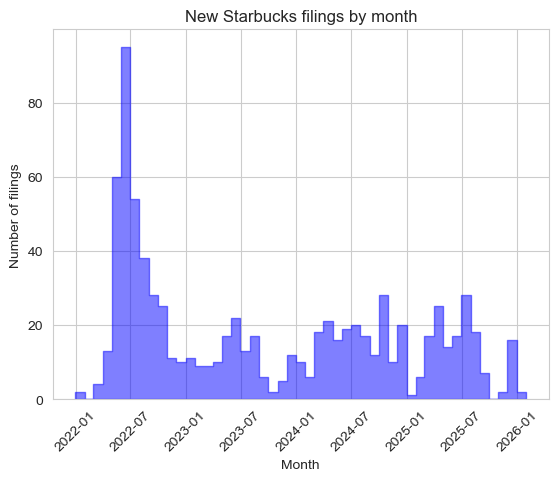

In [60]:
plt.fill_between(filings_per_month.index,filings_per_month, color = 'blue', alpha=0.5, step='pre')
plt.ylabel("Number of filings")
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylim(bottom = 0)
plt.title("New Starbucks filings by month")
plt.show()

### UE

In [61]:
ue_elections = single_elections[single_elections['Union'] == "UE"]

In [62]:
ue_elections.index = ue_elections['Date Closed']

In [63]:
ue_elections.groupby(by = ue_elections['Date Closed'].dt.year)['Outcome'].value_counts()

Date Closed  Outcome
2007         Loss       1
             Win        1
2008         Win        7
             Loss       3
2010         Win        3
             Loss       1
2011         Win        1
2012         Loss       2
             Win        2
2013         Win        1
2014         Loss       1
             Win        1
2015         Win        5
2016         Win        5
2017         Win        4
             Loss       2
2018         Win        1
2019         Win        2
2020         Win        1
2021         Win        2
             Loss       1
2022         Win        2
2023         Win        6
2024         Loss       1
             Win        1
Name: count, dtype: int64

In [64]:
ue_elections['Number Unionized'] = ue_elections['No of Eligible Voters']*ue_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

/var/folders/pz/n_v30dyj09bfnyhk_h1dnfnm0000gn/T/ipykernel_98162/3444951292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_elections['Number Unionized'] = ue_elections['No of Eligible Voters']*ue_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)


In [65]:
number_unionized_by_month = ue_elections['Number Unionized'].resample("ME").sum()

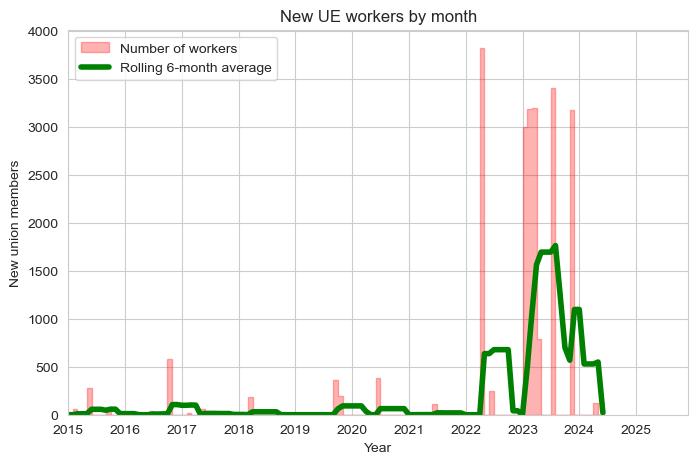

In [67]:
rolling_window = 6
rolling_average_number_by_month = number_unionized_by_month.loc["2014-07":"2025-12"].rolling(rolling_window).mean()
plt.figure(figsize = (8, 5))
plt.fill_between(number_unionized_by_month.loc["2014-12-31":"2025-12"].index, number_unionized_by_month.loc["2014-12-31":"2025-12"],  
                 color = 'red',
                 alpha = 0.3,
                 step='pre',
                label = f"Number of workers")
plt.plot(rolling_average_number_by_month.index, rolling_average_number_by_month, 
                 color = 'green',
                 linewidth = 4,
                label = f"Rolling {rolling_window}-month average")
number_unionized_by_month.loc["2015":"2025-12"]
plt.xlabel("Year")
plt.ylabel("New union members")
plt.ylim(bottom = 0)
plt.xlim(left = pd.to_datetime("2015-01-01"),right = pd.to_datetime("2025-12"))
plt.title(f"New UE workers by month")
plt.legend(loc = 'upper left')
plt.show()

In [68]:
ue_view = ue_elections[['Region', 'Case Number', 'Case Name', 'Status', 'Date Filed','Percent Votes Yes', 'Outcome', 'No of Eligible Voters',
       'Date Closed', 'Reason Closed', 'City', 'States & Territories','Turnout',
       'Number Unionized', 'Duration']].sort_index()
ue_view.index = list(range(len(ue_view)))
ue_view.style.apply(lambda x: 15*['background-color:#AAFFAA' if x['Outcome'] == "Win" else 'background-color:white'], axis = 1)

,Region,Case Number,Case Name,Status,Date Filed,Percent Votes Yes,Outcome,No of Eligible Voters,Date Closed,Reason Closed,City,States & Territories,Turnout,Number Unionized,Duration
0,"Region 22, Newark, New Jersey",22-RC-012310,"Hishi Plastic, Inc.",Closed,2003-02-10 00:00:00,0.846000,Win,42.000000,2007-03-27 00:00:00,Certific. of Representative,Lincoln Park,NJ,0.904762,42.000000,1506.000000
1,"Region 01, Boston, Massachusetts",01-RC-022095,Committee On Temporary Shelter (Cots),Closed,2007-03-02 00:00:00,0.447000,Loss,39.000000,2007-04-12 00:00:00,Certification of Results,Burlington,VT,0.948718,0.000000,41.000000
2,"Region 01, Boston, Massachusetts",01-RC-022172,Choctaw Archiving Enterprises,Closed,2007-12-21 00:00:00,0.622000,Win,87.000000,2008-02-11 00:00:00,Certific. of Representative,Saint Albans,VT,0.942529,87.000000,52.000000
3,"Region 01, Boston, Massachusetts",01-RC-022173,"Northrop Grumman Technical Services, Inc.",Closed,2007-12-21 00:00:00,0.588000,Win,107.000000,2008-02-11 00:00:00,Certific. of Representative,Saint Albans,VT,0.906542,107.000000,52.000000
4,"Region 01, Boston, Massachusetts",01-RC-022174,Federal Working Group,Closed,2007-12-21 00:00:00,0.400000,Loss,20.000000,2008-02-11 00:00:00,Certification of Results,Saint Albans,VT,1.000000,0.000000,52.000000
5,"Region 21, Los Angeles, California",21-RC-021007,Studley Professional Staffing,Closed,2008-01-23 00:00:00,0.742000,Win,34.000000,2008-03-05 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.911765,34.000000,42.000000
6,"Region 21, Los Angeles, California",21-RC-021006,Choctaw Archiving Enterprises,Closed,2008-01-23 00:00:00,0.919000,Win,151.000000,2008-03-06 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.894040,151.000000,43.000000
7,"Region 21, Los Angeles, California",21-RC-021008,"Northrop Grumman Technical Services, Inc., A Subsidiary Of Northrop Grumman Systems Corp.",Closed,2008-01-24 00:00:00,0.724000,Win,154.000000,2008-03-06 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.941558,154.000000,42.000000
8,"Region 21, Los Angeles, California",21-RC-021009,"Stanley Associates, Inc.",Closed,2008-01-24 00:00:00,0.575000,Win,185.000000,2008-03-14 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.962162,185.000000,50.000000
9,"Region 01, Boston, Massachusetts",01-RC-022171,"Stanley Associates, Inc.",Closed,2007-12-21 00:00:00,0.373000,Loss,166.000000,2008-03-20 00:00:00,Certification of Results,Saint Albans,VT,0.843373,0.000000,90.000000


In [338]:
single_elections['Case Name'].unique().shape

(16835,)

In [340]:
single_elections['Case Name'].apply(lambda x: x.lower().replace(" ", "")).unique().shape

(16719,)